# ALICE Masterclass R$_{AA}$

    Laden der erforderlichen Pakete

In [1]:
import ALICE_RAA_Tools as at
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

Liste der verfügbaren Zentralitäten:

    0-5%, 0-10%, 5-10%, 10-20%, 20-30%, 30-40%, 40-50%, 50-60%, 60-70%, 70-80%, 80-90%

__ACHTUNG:__
Hier darf nicht überall die vorhandene Zentralität geändert werden. Die Zentralitätsklasse 70-80% dient später als Referenz für R$_{cp}$ und darf nicht gelöscht werden.
    

In [2]:
listCentralities = [(60,70), (70,80)]

    Erstellen eines Dictionaries

In [3]:
dictCentralities = at.create_dictionary(listCentralities)


processing centrality range: 60-70% - (60/70)
processing centrality range: 70-80% - (70/80)


# 1. Event-Analyse

### 1.1 Einlesen der Events

    Zählen der Events

In [4]:
event_lines = at.count_lines('event_information.csv')
print("Number of events: '" + str(event_lines) + "'!")

Number of events: '118909'!


    Einlesen der Event-Information aus der CSV-Datei

In [5]:
df_events = pd.read_csv("event_information.csv", header=None, names=['eventMult', 'eventCent'])

In [6]:
print(df_events.head())

   eventMult  eventCent
0          4   100.0000
1          1    88.2660
2        275    41.6756
3        449    23.1375
4        267    42.8638


### 1.2 Bearbeiten der Daten

    Hinzufügen von Spalten zum DataFrame für jedes Zentralitätsintervall

In [7]:
for key in dictCentralities:
    df_events[key] = False

print(df_events.head())

   eventMult  eventCent  60-70  70-80
0          4   100.0000  False  False
1          1    88.2660  False  False
2        275    41.6756  False  False
3        449    23.1375  False  False
4        267    42.8638  False  False


    Füllen der Zentralitätsinformation und Bestimmung der Anzahl an Events pro Zentralitätsintervall

In [8]:
dictEventsCent = {}
for row in df_events.iterrows():
    keys = at.find_centralities(dictCentralities, row[1]['eventCent'])
    if keys:
        for cent in keys:
            df_events.loc[row[0], cent] = True
            if cent in dictEventsCent:
                dictEventsCent[cent] += 1
            else:
                dictEventsCent[cent] = 1
                
print(df_events.head())
print(dictEventsCent)

   eventMult  eventCent  60-70  70-80
0          4   100.0000  False  False
1          1    88.2660  False  False
2        275    41.6756  False  False
3        449    23.1375  False  False
4        267    42.8638  False  False
{'60-70': 12102, '70-80': 12247}


### 1.3 Darstellung der Ergebnisse

    Erzeugung & Darstellung der Histogramme zur Teilchenmultiplizität

In [9]:
hTPC_0_100, bins = at.create_event_histos(df_events['eventMult'])
hTPC_60_70, bins = at.create_event_histos(df_events[df_events['60-70'] == True]['eventMult'])
hTPC_70_80, bins = at.create_event_histos(df_events[df_events['70-80'] == True]['eventMult'])

In [10]:
hTPC_0_100_err = np.sqrt(hTPC_0_100)
hTPC_60_70_err = np.sqrt(hTPC_60_70)
hTPC_70_80_err = np.sqrt(hTPC_70_80)

In [11]:
plt.errorbar(bins[:-1], hTPC_0_100, yerr=hTPC_0_100_err, fmt='g+', label='0-100%')
plt.errorbar(bins[:-1], hTPC_60_70, yerr=hTPC_60_70_err, fmt='b+', label='60-70%')
plt.errorbar(bins[:-1], hTPC_70_80, yerr=hTPC_70_80_err, fmt='r+', label='70-80%')
#zu den Einstllungen unter 'fmt' ist folgende Seite nützlich
#https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot

plt.xlabel('Number of TPC tracks')
plt.ylabel('Counts')
plt.ylim(1,2E4)
plt.yscale('log')

plt.legend(loc='upper right')
plt.savefig('TPC_tracks.pdf')

    2D-Plot: Teilchenspurmultiplizität gegen Zentralität

In [12]:
plt.hist2d(df_events['eventMult'],df_events['eventCent'], bins=(200,100), range=[[0, 2000], [0, 100]], cmap=plt.cm.jet, norm=mpl.colors.LogNorm())

plt.colorbar()
plt.xlabel('Number of TPC tracks')
plt.ylabel('Centrality')
plt.savefig('TPC_tracks_2D.pdf')

<ipython-input-12-14b7e873d50e>:1: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.hist2d(df_events['eventMult'],df_events['eventCent'], bins=(200,100), range=[[0, 2000], [0, 100]], cmap=plt.cm.jet, norm=mpl.colors.LogNorm())


# 2. Teilchenspuren und Impulsspektren

    Liste der verfügbaren Zentralitäten:
 
     0-5%, 0-10%, 5-10%, 10-20%, 20-30%, 30-40%, 40-50%, 50-60%, 60-70%, 70-80%, 80-90%

## 2.1 Einlesen der Pb-Pb Daten

In [13]:
print("Number of tracks: '38042122'! ~600MB Datei (ungepackt)")

Number of tracks: '38042122'! ~600MB Datei (ungepackt)


In [14]:
dictMomCent = {}
for key in dictCentralities:
    dictMomCent[key] = []

In [15]:
df_tracks = pd.read_pickle("./track_info.pkl", 'bz2').to_numpy()

### 2.2 Sortieren nach Zentralität

In [16]:
for line in df_tracks:
    keys = at.find_centralities(dictCentralities, line[1])
    if keys:
        for key in keys:
            dictMomCent[key].append(line[0])

### 2.3 Erzeugen der Histogramme

In [17]:
binsPt = at.get_bins()
binWidth = at.get_bin_width(binsPt)
x_bin_width = np.asarray(binWidth)/2

In [18]:
hPbPb_60_70, _ = np.histogram(dictMomCent['60-70'], binsPt)
hPbPb_60_70_err = np.sqrt(hPbPb_60_70) / dictEventsCent['60-70']
hPbPb_60_70 = hPbPb_60_70 / binWidth
hPbPb_60_70 = hPbPb_60_70 / dictEventsCent['60-70']

hPbPb_70_80, _ = np.histogram(dictMomCent['70-80'], binsPt)
# Spezialfall für 70-80%, ein Bin ist Null - problematisch für spätere Division - daher 0 durch 1 ersetzen
hPbPb_70_80 = np.where(hPbPb_70_80==0,1,hPbPb_70_80)
hPbPb_70_80_err = np.sqrt(hPbPb_70_80) / dictEventsCent['70-80']
hPbPb_70_80 = hPbPb_70_80 / binWidth
hPbPb_70_80 = hPbPb_70_80 / dictEventsCent['70-80']

### 2.4 Einlesen der Proton-Proton Referenz

In [19]:
pp = np.genfromtxt('pp_reference.dat')
print(pp)
pp_err = np.divide(pp,10) #Annahme: 10% Fehler auf der pp Messung

[7.45490e+00 7.65275e+00 7.30830e+00 6.69179e+00 5.95329e+00 5.23470e+00
 4.56247e+00 3.95539e+00 3.45216e+00 2.98434e+00 2.59966e+00 2.27798e+00
 1.98687e+00 1.73790e+00 1.52032e+00 1.33769e+00 1.17260e+00 9.74791e-01
 7.62729e-01 6.07263e-01 4.81246e-01 3.84214e-01 3.06867e-01 2.49308e-01
 2.01941e-01 1.64699e-01 1.34966e-01 1.02682e-01 7.11706e-02 4.93115e-02
 3.52670e-02 2.58376e-02 1.86202e-02 1.39077e-02 1.07355e-02 8.15140e-03
 6.29524e-03 3.92350e-03 2.20045e-03 1.29719e-03 8.06745e-04 5.13653e-04
 3.40671e-04 1.98091e-04 9.95690e-05 5.45917e-05 3.35944e-05 2.00772e-05
 1.32163e-05 9.10819e-06 4.99855e-06]


### 2.5 Darstellung der Transversalimpulsspektren geladener Teilchen

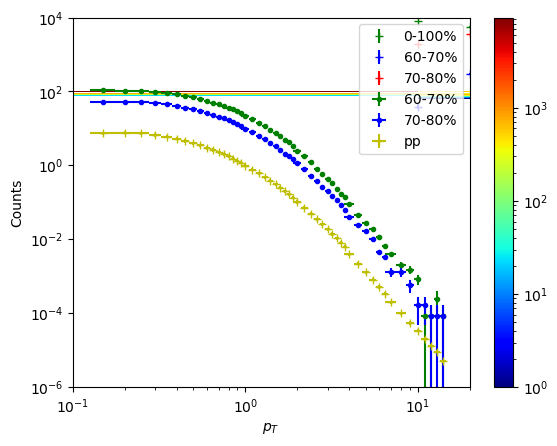

In [20]:
plt.errorbar(binsPt[:-1], hPbPb_60_70, xerr=x_bin_width, yerr=hPbPb_60_70_err, fmt='g.', label='60-70%')
plt.errorbar(binsPt[:-1], hPbPb_70_80, xerr=x_bin_width, yerr=hPbPb_70_80_err, fmt='b.', label='70-80%')
plt.errorbar(binsPt[:-1], pp,          xerr=x_bin_width, yerr=pp_err,          fmt='y+', label='pp')

plt.xscale('log')
plt.yscale('log')
plt.xlim(0.1, 20)
plt.ylim(1E-6, 1E4)

plt.xlabel('$p_{T}$')
plt.ylabel('Counts')
plt.legend(loc='upper right')
plt.show()

### 2.6 Definition der Zentralitätsklassen

Definition der Anzahl an Kollisionen für einzelne Zentralitäten

In [21]:
dictNColl = {'0-5': 1686.87,
             '0-10': 1502.7,
             '5-10': 1319.89,
             '10-20': 923.89,
             '20-30': 558.68,
             '30-40': 321.20,
             '40-50': 171.67,
             '50-60': 85.13,
             '60-70': 38.51,
             '70-80': 15.78,
             '80-90': 6.32,
             'pp':1.
            }

print(dictNColl)

{'0-5': 1686.87, '0-10': 1502.7, '5-10': 1319.89, '10-20': 923.89, '20-30': 558.68, '30-40': 321.2, '40-50': 171.67, '50-60': 85.13, '60-70': 38.51, '70-80': 15.78, '80-90': 6.32, 'pp': 1.0}


### 2.7 Berechnung und Darstellung des R$_{\text{CP}}$

In [22]:
RCP_60_70 = np.divide(hPbPb_60_70 / dictNColl['60-70'], hPbPb_70_80 / dictNColl['70-80'])                                                                

In [23]:
RCP_60_70_err = at.fehlerberechnung(hPbPb_60_70, hPbPb_60_70_err, dictNColl['60-70'], hPbPb_70_80, hPbPb_70_80_err, dictNColl['70-80'])

In [24]:
plt.errorbar(binsPt[:-1], RCP_60_70, xerr=x_bin_width, yerr=RCP_60_70_err, fmt='b.', label='60-70%')

plt.ylim(-0.1,2)
plt.xlabel('$p_{T}$')
plt.ylabel(r'$R_{cp}=\frac{1/N^{AA,X}_{evt}1/<N_{coll,X}>dN^{AA,X}/dp_t}{1/N^{PbPb,per}_{evt}1/<N_{coll,per}>dN^{PbPb,per}/dp_t}$')
plt.legend(loc='upper right')
plt.savefig('RCP_compared.pdf')

### 2.8 Berechnung und Darstellung des R$_\text{AA}$

In [25]:
RAA_60_70 = np.divide(hPbPb_60_70 / dictNColl['60-70'], pp)
RAA_70_80 = np.divide(hPbPb_70_80 / dictNColl['70-80'], pp)

In [26]:
RAA_60_70_err = at.fehlerberechnung(hPbPb_60_70, hPbPb_60_70_err, dictNColl['60-70'], pp, pp_err, dictNColl['pp'])
RAA_70_80_err = at.fehlerberechnung(hPbPb_70_80, hPbPb_70_80_err, dictNColl['70-80'], pp, pp_err, dictNColl['pp'])

In [27]:
plt.errorbar(binsPt[:-1], RAA_60_70, xerr=x_bin_width, yerr=RAA_60_70_err, fmt='b.', label='60-70%')
plt.errorbar(binsPt[:-1], RAA_70_80, xerr=x_bin_width, yerr=RAA_70_80_err, fmt='g.', label='70-80%')

plt.ylim(0.01,1.2)
plt.xlabel('$p_{T}$')
plt.ylabel(r'$R_{AA}=\frac{1/N^{AA}_{evt}dN^{AA}/dp_t}{<N_{coll}>1/N_{pp_{evt}dN^{pp}/dp_t}}$')
plt.legend(loc='upper right')
plt.savefig('RAA_compared.pdf')

Zeige einzelne Werte für R$_{AA}$ bei bestimmten Transversalimpulsen für die Gesamtauswertung

In [28]:
at.get_value_and_error(RAA_60_70, RAA_60_70_err, 5.5)
at.get_value_and_error(RAA_60_70, RAA_60_70_err, 10)

<IPython.core.display.Math object>

<IPython.core.display.Math object>